In [5]:
# Load packages

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import os

# Conda packages used for virtual environment:
# pandas numpy geopandas rasterio contextily fiona ipykernel matplotlib seaborn xarray geowombat rasterstats os

## Getting Geospatial Data

In [6]:
# Import 2018 Congressional data

# Unzip Congressional district shapefile data

path = "./data_2018/2018_us_cd116"

if not os.path.exists(path):
    with zipfile.ZipFile("./data_2018/2018_us_cd116.zip", "r") as zip_ref:
        zip_ref.extractall("./data_2018/2018_us_cd116")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")

Unzipped folder already exists. Skipping extraction.


In [7]:
# Get congressional district spatial data
gdf_cd = gpd.read_file("./data_2018/2018_us_cd116/tl_2018_us_cd116.shp")

# Filter to Ohio (39), Indiana (18), Michigan (26), Pennslyvania (42), Wisconsin (55), & Missiouri (29)
gdf_cd = gdf_cd[gdf_cd['STATEFP'].isin(['18', '26', '29', '39', '42', '55'])]

state_map = {
    '39': 'Ohio',
    '18': 'Indiana',
    '26': 'Michigan',
    '42': 'Pennsylvania',
    '55': 'Wisconsin',
    '29': 'Missouri'
}

gdf_cd.head()

gdf_cd['STATE'] = gdf_cd['STATEFP'].map(state_map)
gdf_cd['CD_ID'] = gdf_cd['STATE'] + ' ' + gdf_cd['CD116FP']

# Limit to specified columns
columns_gdf_cd = ['CD_ID', 'GEOID', 'geometry']
gdf_cd = gdf_cd[columns_gdf_cd]

# Preview
print(gdf_cd.head())

         CD_ID GEOID                                           geometry
15  Indiana 02  1802  POLYGON ((-86.93100 40.95794, -86.93100 40.958...
16  Indiana 09  1809  POLYGON ((-86.68566 39.32122, -86.68569 39.322...
17  Indiana 06  1806  POLYGON ((-86.08560 39.34419, -86.08524 39.344...
18  Indiana 08  1808  POLYGON ((-88.09776 37.90403, -88.09566 37.905...
30  Indiana 01  1801  POLYGON ((-87.52676 41.30832, -87.52674 41.311...


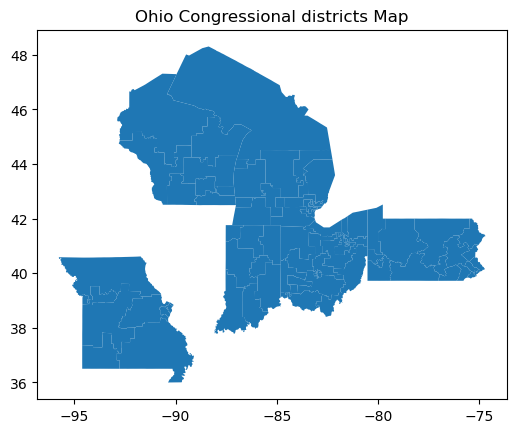

In [8]:
# Reprojecting to epsg:4326

gdf_cd_proj = gdf_cd.to_crs(epsg=4326)

# Map reprojected data
gdf_cd_proj.plot()
plt.title("Ohio Congressional districts Map")
plt.show()

In [ ]:
gdf_cd_proj.head()

# TO DO: Convert CD_ID to two variables: State & CD116FP

,CD_ID,GEOID,geometry
15,Indiana 02,1802,"POLYGON ((-86.93100 40.95794, -86.93100 40.958..."
16,Indiana 09,1809,"POLYGON ((-86.68566 39.32122, -86.68569 39.322..."
17,Indiana 06,1806,"POLYGON ((-86.08560 39.34419, -86.08523 39.344..."
18,Indiana 08,1808,"POLYGON ((-88.09776 37.90402, -88.09566 37.905..."
30,Indiana 01,1801,"POLYGON ((-87.52676 41.30832, -87.52673 41.311..."
